In [2]:
"""
Implementation of a simple multivalent binding model.
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.optimize import minimize, curve_fit
from src.MBmodel import cytBindingModel, resids, residsSeq, fitFunc, getConfInterval, getConfIntervalSeq 

/usr/local/lib/python3.9/dist-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
0.7863581451206296


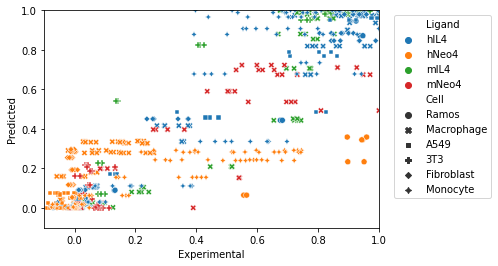

In [2]:
xOpt = [-14., 0.67117646, 10.28419558, 4., 4.35477332, 7.21820434, 4.4905906, 10.50611831, 5.83553544, 7.28585079, 9.03802116, 5.40071701, 1.9911352 ]
#xOpt = [-10.53250838, 0.01192143, 9.52568895, 8.05298022, 5.34542389, 6.5733771, 7.32127153, 4.67347371, 10.00887475, 6.11455606, 6.78746333, 8.83742865, 6.15951505, 5.08588467]
modelDF = resids(xOpt, True)
sns.scatterplot(data=modelDF, x="Experimental", y="Predicted", hue="Ligand", style="Cell")
plt.xlim(-.1, 1)
plt.ylim(-.1, 1)
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0))
#plt.savefig("UnConstrainedFit.svg")
print(r2_score(modelDF.Experimental.values, modelDF.Predicted.values))


In [25]:
np.power(np.power(10, xOpt[2::]), -1) * np.power(10, 9)

array([1.38819041e+19, 3.02525356e+06, 2.19780127e+00, 1.63178099e+02,
       1.31474819e+01, 2.62818480e+02, 1.25020874e+03, 5.58856170e+02,
       2.09968860e-01, 9.85037672e+02, 4.57039431e+00, 1.38785924e+00,
       1.38116161e+04, 1.31337940e+03])

In [44]:
from scipy.optimize import root, least_squares

def IL4Func(x, KDs, recs, conc):
    print(x, (x*conc)/KDs[0], recs[1]/((KDs[0]*KDs[1])/(x*conc)+1), recs[2]/((KDs[0]*KDs[2])/(x*conc)+1))
    return recs[0] - (x + (x*conc)/KDs[0] + recs[1]/(KDs[0]*KDs[1]/(x*conc)+1) + recs[2]/((KDs[0]*KDs[2])/(x*conc)+1))

KDs = [1e-7, 10, 5]
recs = [400, 5000, 10000]
conc = 1e-11
x0 = 1000
bnds = ((0, recs[0]))

IL4Ra = least_squares(IL4Func, x0=recs[0], args=(KDs, recs, conc)).x

def SignalingFunc(IL4Ra, KDs, recs, conc, T2W):
    return recs[1]/(KDs[0]*KDs[1]/(IL4Ra*conc)+1) + recs[2]/((KDs[0]*KDs[2])/(IL4Ra*conc)+1) * T2W

print(SignalingFunc(IL4Ra, KDs, recs, conc, 1))
    

[400.] [0.04] [19.92031873] [79.36507937]
[400.00000596] [0.04] [19.92031902] [79.36508054]
[320.31914882] [0.03203191] [15.96481907] [63.65602489]
[320.31915359] [0.03203192] [15.96481931] [63.65602583]
[320.34157854] [0.03203416] [15.9659334] [63.6604539]
[320.34158331] [0.03203416] [15.96593364] [63.66045484]
[79.6263873]


xOpts Length 5


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


0.6943643209652557


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


modelDFs Length 5


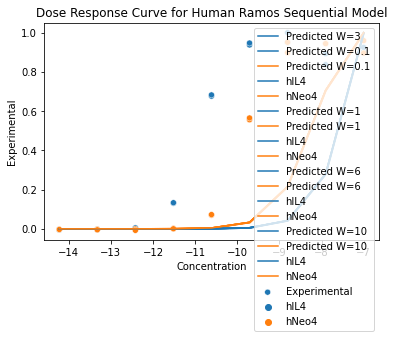

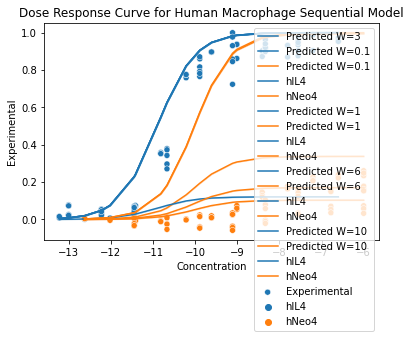

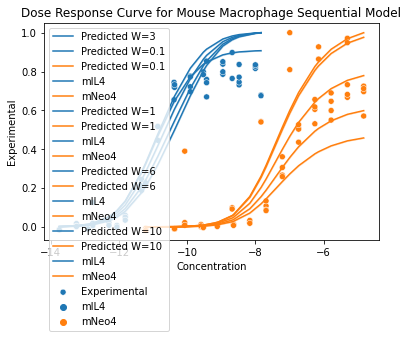

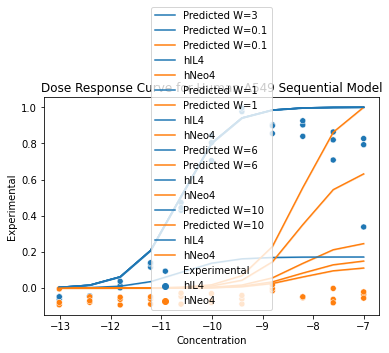

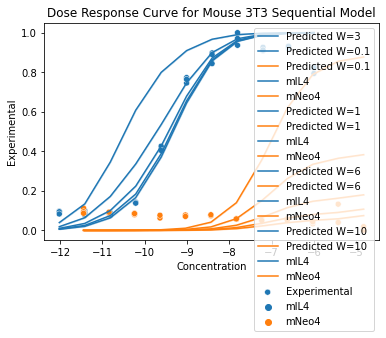

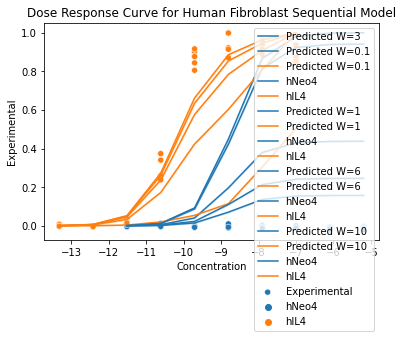

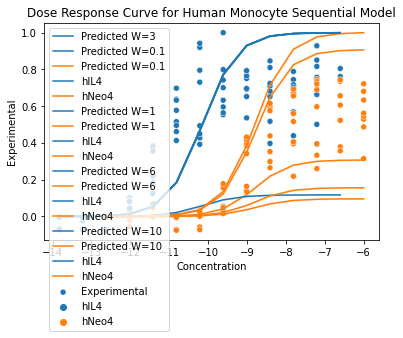

In [8]:
xOptimal = pd.read_csv("src/data/CurrentFitSeq.csv").x.values


#Generate range of xOptimals
xOpts = [xOptimal]

weights = [0.1,1,6,10]

for weight in weights:
    xOptimal_new = np.copy(xOptimal)
    xOptimal_new[0] = weight
    xOpts.append(xOptimal_new)

print("xOpts Length "+ str(len(xOpts)))
#Generate range of models
modelDF = residsSeq(xOptimal, True)
print(r2_score(modelDF.Experimental.values, modelDF.Predicted.values))

modelDFs = [modelDF]

for i in range(1,len(xOpts)):
    modelDF_new = residsSeq(xOpts[i], True)
    modelDFs.append(modelDF_new)

print("modelDFs Length "+ str(len(modelDFs)))




for cell in modelDF.Cell.unique():
    for animal in modelDF.loc[modelDF.Cell == cell].Animal.unique():
        weights = [3,0.1,1,6,10]
        isoData = modelDF.loc[(modelDF.Cell == cell) & (modelDF.Animal == animal)]
        fig, ax = plt.subplots()
        sns.scatterplot(data=isoData, x="Concentration", y="Experimental", label="Experimental", hue="Ligand")
        for i, modelDF_ in enumerate(modelDFs):
            isoData_ = modelDF_.loc[(modelDF_.Cell == cell) & (modelDF_.Animal == animal)]
            sns.lineplot(data=isoData_, x="Concentration", y="Predicted", label="Predicted W="+str(weights[i]), hue="Ligand")
        ax.set_title("Dose Response Curve for " + animal + " " + cell + " Sequential Model")
        handles, labels = ax.get_legend_handles_labels()
        ax.legend([handles[0]] + handles[4::], [labels[0]] + labels[4::])
        #plt.savefig("UnConstrained"+animal+cell+".svg")

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)
0.7733085354018433


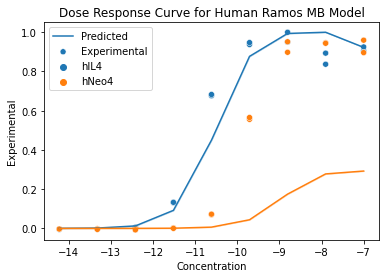

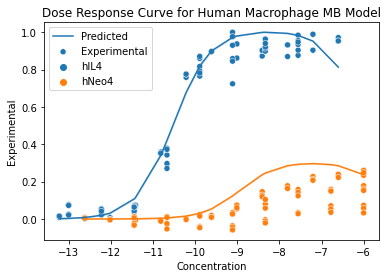

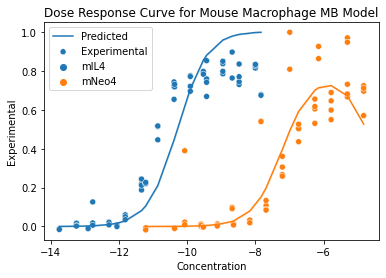

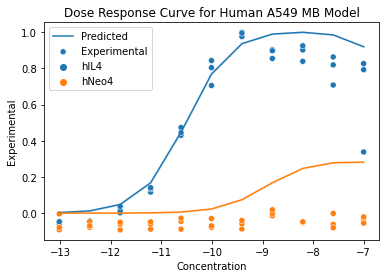

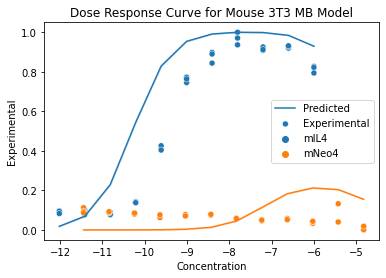

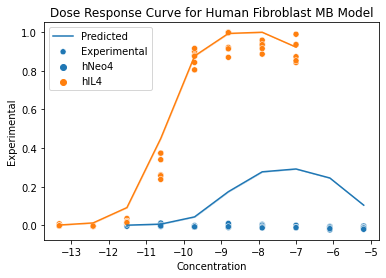

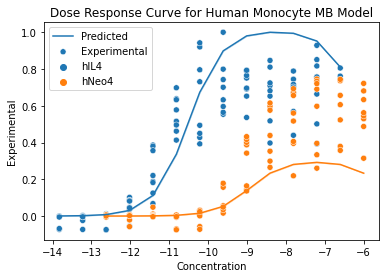

In [3]:
xOptimal = pd.read_csv("src/data/CurrentFit.csv").x.values
modelDF = resids(xOptimal, True)
print(r2_score(modelDF.Experimental.values, modelDF.Predicted.values))

for cell in modelDF.Cell.unique():
    for animal in modelDF.loc[modelDF.Cell == cell].Animal.unique():
        isoData = modelDF.loc[(modelDF.Cell == cell) & (modelDF.Animal == animal)]
        fig, ax = plt.subplots()
        sns.scatterplot(data=isoData, x="Concentration", y="Experimental", label="Experimental", hue="Ligand")
        sns.lineplot(data=isoData, x="Concentration", y="Predicted", label="Predicted", hue="Ligand")
        ax.set_title("Dose Response Curve for " + animal + " " + cell + " MB Model")
        handles, labels = ax.get_legend_handles_labels()
        ax.legend([handles[0]] + handles[4::], [labels[0]] + labels[4::])
        #plt.savefig("UnConstrained"+animal+cell+".svg")

In [ ]:
xOptimal = pd.read_csv("src/data/CurrentFit.csv").x.values
modelDF = resids(xOptimal, True)
print(r2_score(modelDF.Experimental.values, modelDF.Predicted.values))

for cell in modelDF.Cell.unique():
    for animal in modelDF.loc[modelDF.Cell == cell].Animal.unique():
        isoData = modelDF.loc[(modelDF.Cell == cell) & (modelDF.Animal == animal)]
        fig, ax = plt.subplots()
        sns.scatterplot(data=isoData, x="Concentration", y="Experimental", label="Experimental", hue="Ligand")
        sns.lineplot(data=isoData, x="Concentration", y="Predicted", label="Predicted", hue="Ligand")
        ax.set_title("Dose Response Curve for " + animal + " " + cell + " MB Model")
        handles, labels = ax.get_legend_handles_labels()
        ax.legend([handles[0]] + handles[4::], [labels[0]] + labels[4::])